In [1]:
import tensorflow as tf
import pandas as pd
from scipy.io import loadmat

In [2]:
%matplotlib inline

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11411702796837781506, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 10826501325
 locality {
   bus_id: 1
 }
 incarnation: 1953974143529017800
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0"]

In [5]:
# Download Data set from web
from urllib.request import urlretrieve
from os.path import isfile
def download():
    """Download dataset from web and save into a specific direcotory"""
    train_url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
    test_url = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'
    if not isfile("data/train_32x32.mat"):
        print("start download")
        urlretrieve(train_url, filename="data/train_32x32.mat")
        print("train data downloaded")
    else:
        print("train data exsits")
    if not isfile("data/test_32x32.mat"):
        print("start download test data")
        urlretrieve(test_url, filename="data/test_32x32.mat")
        print("download finished")
    else:
        print("test data exists")

In [6]:
# test download
# download()
# test download file exits
download()

train data exsits
test data exists


In [7]:
# read mat data
train_data = loadmat("data/train_32x32.mat")
test_data = loadmat("data/test_32x32.mat")

In [8]:
# test whether the data is loaded
assert train_data.get("X").shape == (32, 32, 3, 73257)
assert test_data.get("X").shape == (32, 32, 3, 26032)

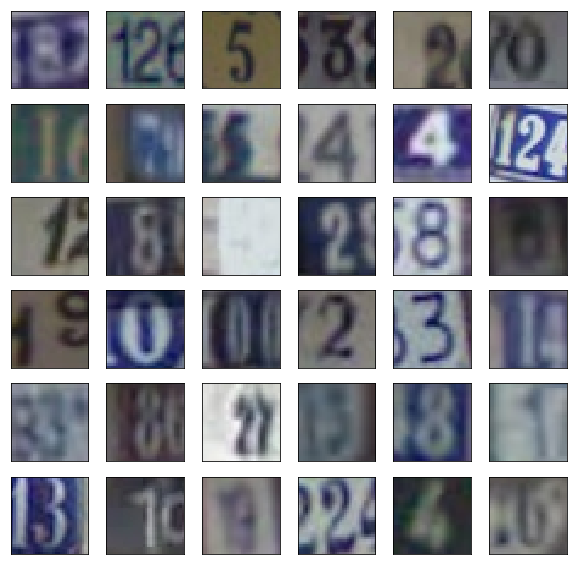

In [9]:
# show images in 6 x 6 grids
from matplotlib import pyplot as plt
import numpy as np
fig, ax = plt.subplots(6, 6, sharex=False, sharey=False, figsize=(10, 10))
assert type(ax) == np.ndarray
indexes = np.random.randint(0, train_data["X"].shape[3], size=36)
for idx, axe in zip(indexes, ax.reshape(-1)):
    # print(idx, axe)
    axe.imshow(train_data["X"][:,:,:,idx])
    # 取消多余的图片横轴竖轴
    axe.xaxis.set_visible(False) 
    axe.yaxis.set_visible(False) 
plt.show()

In [10]:
# 处理图片的输入, 像素归一化, 范围(-1, 1) 符合generator的正态分布
# 这里不使用正态分布而是平移的原因是, 不知道图片的像素分布, 所以不一定使用正态分布.
# ver1.0:输入图片的array, [0, 255], 返回[-1,1].
# ver1.1:边界条件, 范围变化, 不是0到255, 例如(17, 239)
def scale(image, scale_range = (-1, 1)):
    """输入图片像素矩阵, 返回归一化图片矩阵"""
    # scale to (0, 1)
    scale_min, scale_max = scale_range
    image_min = np.min(image)
    image_max = np.max(image)
    image = (image - image_min) / (image_max - image_min)
    # scale to (-1, 1)
    image = image*2 + scale_min
    return image

In [11]:
# test scale
image_for_test = np.random.randint(0, 255, 5*5).reshape(5, 5)
assert np.max(scale(image_for_test)) <= 1 and np.min(scale(image_for_test)) >= -1
scale(image_for_test)

array([[ 0.23694779, -0.91967871,  0.10040161,  0.12449799,  0.86345382],
       [-0.89558233,  0.69477912,  0.26907631, -0.26104418, -0.67871486],
       [ 1.        , -0.5502008 , -0.91164659,  0.54216867, -0.11646586],
       [ 0.85542169, -1.        , -0.27710843,  0.82329317, -0.87148594],
       [-0.6626506 , -0.33333333, -0.92771084,  0.63052209,  0.4939759 ]])

In [12]:
# batch化输入
class Dataset():
    def __init__(self, train, test, val_frac=0.5, scale_func = scale):
        '''门牌号的图是分成训练集和测试集, 所有的训练集合作为训练用, 测试集对半分作为validation和test'''
        assert train['X'].shape[-1] > 3 # 形状应该是 width x height x 3 x m
        split_idx = int((1 - val_frac) * len(test['y']))
        self.test_x, self.val_x = test["X"][:, :, :, :split_idx], test['X'][:, :, :, split_idx:]
        self.test_y, self.val_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        # reshape to a normal size like m w h 3
        self.test_x = np.rollaxis(self.test_x, 3)
        self.val_x = np.rollaxis(self.val_x, 3)
        self.train_x = np.rollaxis(self.train_x, 3)
        # set mask
        self.mask_labels = np.zeros_like(self.train_y)
        self.mask_labels[:1000] = 1
        # scale the image
        self.test_x = scale_func(self.test_x)
        self.train_x = scale_func(self.train_x)
        
        
    def batch(self, batch_size, which_set="train"):
        "输入一个batch_size, 数据集的名字, 输出一个batch size 的数据,包括图片以及标签"
        data = which_set + "_x"
        lable = which_set + "_y"
        length = len(getattr(self, data))
        # n_batches = length / batch_size
        # shuffle data
        idx = np.arange(0, length)
        np.random.shuffle(idx)
        setattr(self, data, getattr(self, data)[idx])
        setattr(self, lable, getattr(self, lable)[idx])
        # 遮住的标签也需要按照相同序列排序
        if which_set == "train":
            self.mask_labels = self.mask_labels[idx]
        # 按照size划分batch
        for ii in range(0, length, batch_size):
            x = getattr(self, data)[ii:ii+batch_size]
            y = getattr(self, lable)[ii:ii+batch_size]
            ii += batch_size
            if which_set == "train":
                yield x, y, self.mask_labels[ii:ii+batch_size]
            else:
                yield x, y

In [13]:
# test
dataset = Dataset(train_data, test_data)
assert dataset.test_x.shape[-1] == 3
assert np.max(dataset.train_x) <= 1 and np.min(dataset.train_x) >= -1
'''
before_shuffle = dataset.train_x
dataset.batch(1)
after_shuffle = dataset.train_x
assert not np.array_equal(before_shuffle, after_shuffle)
'''
batch_size = 256
for x, y in dataset.batch(batch_size, which_set="test"):
    assert len(x) <= batch_size
    assert len(y) <= batch_size

In [14]:
# placeholders in†he model
def model_inputs(image_dim, z_dim):
    """
    输入图片的大小(width, height, channel), 噪音的分布细度(int)
    返回placeholder的顺序, images, labels, maskes, noise    
    """
    images = tf.placeholder(dtype=tf.float32, shape=(None, *image_dim), name="Input_image")
    labels = tf.placeholder(dtype=tf.int16, shape=(None), name="labels")
    maskes = tf.placeholder(dtype=tf.int16, shape=(None), name="masks")
    noise = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="noise")
    return images, labels, maskes, noise

In [15]:
# test
tf.reset_default_graph()
model_inputs((32, 32, 3), 100)

(<tf.Tensor 'Input_image:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'labels:0' shape=<unknown> dtype=int16>,
 <tf.Tensor 'masks:0' shape=<unknown> dtype=int16>,
 <tf.Tensor 'noise:0' shape=(?, 100) dtype=float32>)

In [16]:
def generator(noise, alpha, training=True, dim=128, reuse=False):
    '''
    noise -> fc -> bn -> leakyrelu -> dcnn
    dcnn -> bn -> leakyrelu -> ...
    
    return -> image(m, 32, 32, 3)
    '''
    with tf.variable_scope("generator", reuse=reuse):
        x1 = tf.layers.dense(noise, 4*4*4*dim)
        x1 = tf.reshape(x1, (-1, 4, 4, 4*dim))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha*x1, x1)
        # 4, 4, 512

        x2 = tf.layers.conv2d_transpose(x1, 2*dim, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(x2, alpha*x2)
        # 8 8 256

        x3 = tf.layers.conv2d_transpose(x2, dim, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha*x3, x3)
        # 16 16 128

        x4 = tf.layers.conv2d_transpose(x3, 3,5, strides=2, padding='same')
        # 32 32 3
        x4 = tf.nn.tanh(x4, name="generator_output")
    return x4

In [17]:
# test
tf.reset_default_graph()
sess = tf.InteractiveSession()
dataset = Dataset(train_data, test_data)
image_dim = (32, 32, 3)
z_dim = 100
images, labels, maskes, noise = model_inputs(image_dim, z_dim)
output = generator(noise, 0.01)
initializer = tf.global_variables_initializer()
sess.run(initializer)
for x, y, mask in dataset.batch(256):
    generator_output = sess.run(output, feed_dict={images: x, 
                                                   labels: y,
                                                   maskes: mask,
                                                   noise: np.random.normal(size=(256, 100))})
    assert generator_output.shape == (256, 32, 32, 3)

In [18]:
def discriminator(image, reuse=False, dropout_rate=0.5, output_channel=64, alpha=0.01, training=True, class_nums=11):
    '''更具DCGAN里面的层数设定
    第一层: image -> dropout
    第二层: iamge -> CNN -> bn -> relu -> dp
    ...
    对于4, 5, 7使用stride为1的采样.
    '''
    with tf.variable_scope("discriminator", reuse=reuse):
        # image ? 32 32 3
        x = tf.layers.dropout(image, rate=dropout_rate)
        
        x1 = tf.layers.conv2d(x, filters=output_channel, kernel_size=3, strides=2, padding='same')
        x1_relu = tf.maximum(alpha * x1, x1)
        x1_dropout = tf.layers.dropout(x1_relu, rate=dropout_rate)
        # x1 shape == (?, 16, 16, 64)
        x2 = tf.layers.conv2d(x1_dropout, output_channel, 3, 2, padding='same')
        x2_bn = tf.layers.batch_normalization(x2, training=training)
        x2_relu = tf.maximum(alpha*x2_bn, x2_bn)
        # 8, 8, 64
        x3 = tf.layers.conv2d(x2_relu, output_channel, 3, 2, padding='same')
        x3_bn = tf.layers.batch_normalization(x3, training=training)
        x3_relu = tf.maximum(alpha * x3_bn, x3_bn)
        x3_dropout = tf.layers.dropout(x3_relu, rate=dropout_rate)
        # 4, 4, 64
        x4 = tf.layers.conv2d(x3_dropout, 2*output_channel, 3, 1, padding='same')
        x4_bn = tf.layers.batch_normalization(x4, training=training)
        x4_relu = tf.maximum(alpha*x4_bn, x4)
        # 4, 4, 128
        x5 = tf.layers.conv2d(x4_relu, 2* output_channel, 3, 1, padding='same')
        x5_bn = tf.layers.batch_normalization(x5, training=training)
        x5_relu = tf.maximum(alpha * x5_bn, x5_bn)
        # 4, 4, 128
        x6 = tf.layers.conv2d(x5_relu, 2*output_channel, 3, 2, padding='same')
        x6_bn = tf.layers.batch_normalization(x6, training=training)
        x6_relu = tf.maximum(alpha*x6_bn, x6_bn)
        x6_dp = tf.layers.dropout(x6_relu, rate=dropout_rate, name='x6_dropout')
        # 2, 2, 128
        
        x7 = tf.layers.conv2d(x5, 2*output_channel, 3, 1, padding='valid')
        x7_relu = tf.maximum(x7, alpha*x7)
        
        # use global average pooling layer
        features = tf.reduce_mean(x7_relu, axis=(1, 2), name="features")
        class_logits = tf.layers.dense(x7_relu, class_nums)
        
        
    return features

In [19]:
# test
tf.reset_default_graph()
sess = tf.InteractiveSession()
dataset = Dataset(train_data, test_data)
image_dim = (32, 32, 3)
z_dim = 100
images, labels, maskes, noise = model_inputs(image_dim, z_dim)
output = discriminator(images)
initializer = tf.global_variables_initializer()
sess.run(initializer)
for x, y, mask in dataset.batch(256):
    output_layer = sess.run(output, feed_dict={images: x, 
                                                   labels: y,
                                                   maskes: mask,
                                                   noise: np.random.normal(size=(256, 100))})
    print(output_layer.shape)

(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)
(256, 128)